# Child Speech Patterns

I wanted to learn more about Natural Language Processing and applying it to speech development in children. This notebook is my first attempt at findings patterns of children's speech at different ages and possibly predicting the age of a child based on speech patterns.

I found some transcripts of kids talking with their moms at childes.talkbank.org. 

I chose to only look at the children's speech in this study, so the text is made up of only the child's speech (not the mom's speech).

## Importing Necessary Libraries 

In [217]:
import os
import glob
from pprint import pprint
import numpy as np
import pandas as pd
pd.set_option('display.width', 2000)
from datetime import time
import urllib.request, urllib.parse, urllib.error
from bs4 import BeautifulSoup
import re
from collections import Counter
from nltk import word_tokenize, FreqDist, pos_tag
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib


%matplotlib inline

## Importing Bloom Transcripts From childes.talkbank.org

In [218]:
main_url = 'https://childes.talkbank.org/browser/index.php?url=Eng-NA/Bloom73/'

def grab_html(url):
    """
    Args:
        url (str) - website address
    Returns:
        soup (soup object)
    """
    
    html = urllib.request.urlopen(url).read()
    soup = BeautifulSoup(html, 'html.parser')
    return soup


main_soup = grab_html(main_url)


# Retrieve the links to all transcripts
link_list = []
for a in main_soup.find_all('a', href = True)[4:]:
    link_list.append(a['href'])

print('There are %d links (transcripts).\n' % len(link_list))
print(link_list)
print('\nJust a second...')


# Get the html for each of the found transcripts
soup_list = []
for link in link_list:
    soup = grab_html(link)
    soup_list.append(soup)
    
print('\nAdded %d transcripts to our list.' % len(soup_list))

There are 6 links (transcripts).

['https://childes.talkbank.org/browser/index.php?url=Eng-NA/Bloom73/010421.cha', 'https://childes.talkbank.org/browser/index.php?url=Eng-NA/Bloom73/010714.cha', 'https://childes.talkbank.org/browser/index.php?url=Eng-NA/Bloom73/010821.cha', 'https://childes.talkbank.org/browser/index.php?url=Eng-NA/Bloom73/011000.cha', 'https://childes.talkbank.org/browser/index.php?url=Eng-NA/Bloom73/020400.cha', 'https://childes.talkbank.org/browser/index.php?url=Eng-NA/Bloom73/021000.cha']

Just a second...

Added 6 transcripts to our list.


## Import Brown Transcripts From Local txt Files

In [219]:
path = '/Users/Jackie/nltk_data/corpora/CHILDES/Brown/Sarah/*.txt'
files = glob.glob(path)

text = []
for file in files:
    with open(file) as f:
        text.append(f.read())

#print(text[0])

## Cleaning Up the Transcripts to Include Only The Child's Speech

In [220]:
# Filter the html from the Bloom transcripts to just the speech parts
speech_list = []
for soup in soup_list:
    speech = soup.find('pre').text
    speech_list.append(speech)
print('Length of speech_list:', len(speech_list))

# Add the Brown transcripts to the speech_list
for t in text:
    speech_list.append(t)
print('Updated length of speech list:', len(speech_list))
#print(speech_list[0])

Length of speech_list: 6
Updated length of speech list: 145


In [221]:
# Filter speech to get just the child's speech
child_speech_list = []
speech_labels = []
for speech in speech_list:
    child_speech_list.append(re.findall('\*CHI:\t(.*)', speech))
    speech_labels.append(str(re.findall(r'\|CHI\|(.*?)\|', speech)))
    
speech_labels = [re.sub('\[|\]|', '', label) for label in speech_labels] 
speech_labels = [label.replace("'", '') for label in speech_labels]

print(speech_labels)

['1;4.21', '1;7.14', '1;8.21', '1;10.0', '2;4.0', '2;10.0', '2;3.05', '2;3.07', '2;3.19', '2;3.22', '2;3.26', '2;3.28', '2;4.10', '2;4.12', '2;4.17', '2;4.19', '2;4.26', '2;5.07', '2;5.15', '2;5.25', '2;5.30', '2;6.04', '2;6.13', '2;6.20', '2;6.30', '2;7.05', '2;7.12', '2;7.18', '2;7.28', '2;8.02', '2;8.25', '2;8.25', '2;9.0', '2;9.06', '2;9.14', '2;9.20', '2;9.29', '2;10.05', '2;10.11', '2;10.20', '2;10.24', '2;11.02', '2;11.17', '2;11.23', '2;11.30', '3;0.18', '3;0.18', '3;0.27', '3;1.03', '3;1.10', '3;1.17', '3;1.24', '3;2.02', '3;2.10', '3;2.16', '3;2.23', '3;3.07', '3;3.07', '3;3.13', '3;3.20', '3;3.28', '3;4.01', '3;4.09', '3;4.16', '3;4.26', '3;5.01', '3;5.07', '3;5.13', '3;5.20', '3;6.06', '3;6.16', '3;6.23', '3;6.30', '3;7.09', '3;7.16', '3;7.23', '3;7.30', '3;8.06', '3;8.12', '3;8.20', '3;8.27', '3;9.03', '3;9.18', '3;9.26', '3;9.26', '3;10.01', '3;10.09', '3;10.16', '3;10.30', '3;11.09', '3;11.16', '3;11.29', '4;0.05', '4;0.14', '4;0.28', '4;1.04', '4;1.11', '4;1.18', '4;1.2

In [222]:
# remove the space and period after every utterance
child_speech_list = [[re.sub('\s\.', '', line) for line in speech] 
                     for speech in child_speech_list]

# remove the comments made in square brackets (ie [grunting])
child_speech_list = [[re.sub('\[.*\]', '', line) for line in speech] 
                     for speech in child_speech_list]

# Change "O" to "oh"
child_speech_list = [[re.sub('0', 'oh', line) for line in speech] 
                     for speech in child_speech_list]

# remove symbols within speech (ie .@<[]&+!() )
child_speech_list = [[re.sub(r'[&:@<>().?!+=]', '', line) for line in speech] 
                     for speech in child_speech_list]

# remove inaudible words "xxx" and "yyy" from speech
child_speech_list = [[re.sub('xxx|yyy', '', line) for line in speech] 
                     for speech in child_speech_list]

# remove utterances left empty after removing inaudible
child_speech_list = [[re.sub(r'^\s*$', '', line) for line in speech] 
                     for speech in child_speech_list]

child_speech_list = [[x for x in speech if x] for speech in child_speech_list]

print(child_speech_list[30])

['yes', ' you microphone', 'microphone ', ' microphone off ', ' on ', 'my ', 'mine a back', 'oh', 'laughs', 'swimming', 'he ', 'a ', 'wawa ', 'I  dere ', 'a gone', 'it gone', 'a see God', 'a see God', ' see God', 'Daddy took away', 'Daddy took away', 'he put  bag', 'he put bag', 'bag', 'yes', 'yes', 'where ', 'oh ', ' shoot', 'dat  cute', "he's cute", 'a Beaver', 'Beaver', 'my doggie', 'yes', 'de  fishie ', 'yes', 'de  fishie water', 'I want ', 'dis  fishie ', 'a bubbles', ' bubbles', 'right here ', 'Mummy  ', 'fishie', 'fishie', 'fishie', 'fishie', 'fishie', 'fishie', 'fishie', 'fishie', 'dump dis ', 'de  fishies', 'de  fishies', 'de  fishies', 'here  Mummy', 'you want more ', 'I want more', 'water', 'woe ', 'nope', 'nope', 'a hot', 'a hot  Mummy', 'it hot  yeah', 'yeah  it cold', "no you don't  no you don't", "no you don't", "no you don't", "no you don't", 'poor fishie', 'goodbye  goodbye   goodbye', ' rock', 'go away', 'he go away', 'bite you', 'bite you', '  Mummy', ' here  Mommy',

## Format the Age of the Child into Number of Months

In [223]:
df = pd.DataFrame()

def format_age(label):
    """
    Args:
        label (str or object) - child's age in CHA format (1;11,02)
    Returns:
        age (float) of child in months
    """
    age = 0
    years = re.findall('(.*);', label)
    age += float(years[0]) * 12
    months = re.findall(';(.*)\.', label)
    age += float(months[0])
    days = re.findall('\.(.*)', label)
    if float(days[0]) >= 15:
        age += 1
    
    return int(age)

df['age'] = [format_age(label) for label in speech_labels]
#print(df)

## Number of Utterances within a Speech

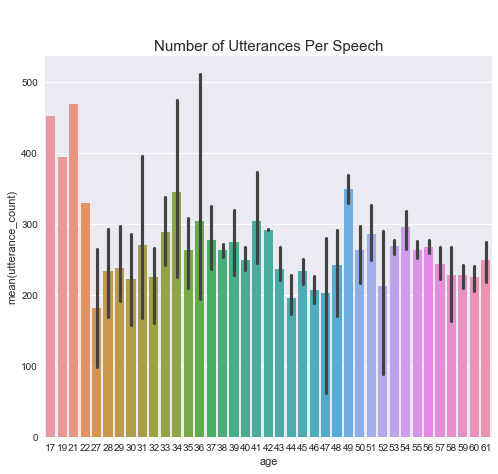

In [224]:
df['utterance_count'] = [len(speech) for speech in child_speech_list]

df

fig = plt.figure(figsize=(8, 7))
_ = sns.barplot(x = 'age', y = 'utterance_count', data = df)
_ = plt.title('\n\nNumber of Utterances Per Speech', size = 15)

## Total Word Count

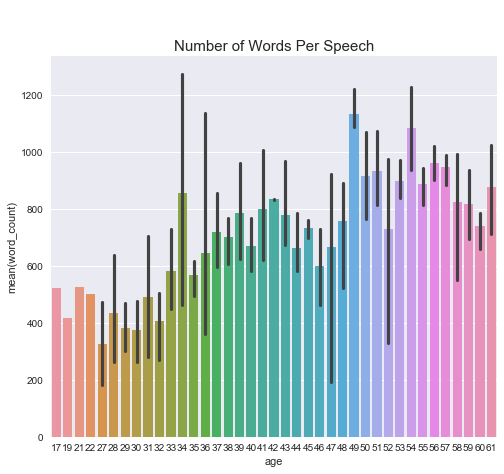

In [225]:
def word_count(speech):
    """
    Args:
        speech (str or list object) - speech corpus
    Returns:
        word count per speech (float)
    """
    
    word_count = []
    
    for line in speech:
        count = len(line.split())
        word_count.append(count)

    return sum(word_count)

df['word_count'] = [word_count(speech) for speech in child_speech_list]

fig = plt.figure(figsize=(8, 7))
_ = sns.barplot(x = 'age', y = 'word_count', data = df)
_ = plt.title('\n\nNumber of Words Per Speech', size = 15)
plt.show()

## Unique Word Count

## Average Number of Words per Utterance

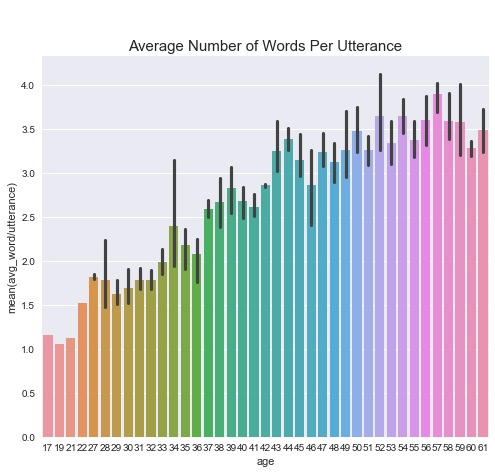

In [184]:
df['avg_word/utterance'] = df['word_count'] / df['utterance_count']
df


fig = plt.figure(figsize=(8, 7))
_ = sns.barplot(x = 'age', y = 'avg_word/utterance', data = df)
_ = plt.title('\n\nAverage Number of Words Per Utterance', size = 15)
plt.show()

## Average Length of Words in Speech

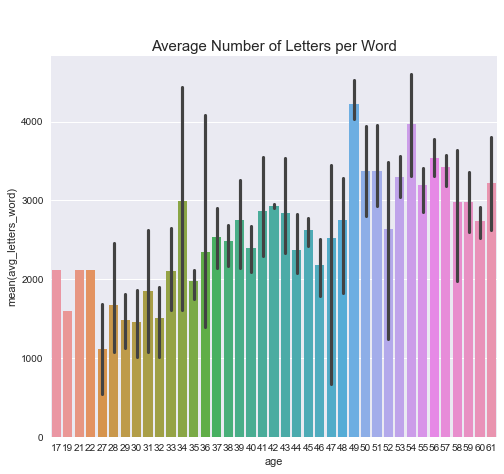

In [185]:
def avg_letters_word(speech):
    """
    Args:
        speech (str or list object) - speech corpus
    Returns:
        average word length speech(float)
    """
    
    letter_count = []
    
    for line in speech:
        words = line.split()
        for word in words:
            letters = list(word)
            num_letters = len(letters)
            letter_count.append(num_letters)
    
    return sum(letter_count)

df['avg_letters_word'] = [avg_letters_word(speech) for speech in child_speech_list]

fig = plt.figure(figsize=(8, 7))
_ = sns.barplot(x = 'age', y = 'avg_letters_word', data = df)
_ = plt.title('\n\nAverage Number of Letters per Word', size = 15)
plt.show()

## Words Used Most Frequently

In [216]:
def top_10(speech):
    """
    Args:
        speech (str or list object) - speech corpus
    Returns:
        list of top 10 most frequent words (list)
    """
    
    words_list = []
    for line in speech:
        words = line.split()
        for word in words:
            words_list.append(word)
        
    freq_dist = FreqDist(words_list)
    most_freq = []
    for word in freq_dist.most_common(10):
        most_freq.append(word)
    #print('Most Frequent Words:\n', most_freq, '\n')
    return most_freq


df['top_10_words'] = [top_10(speech) for speech in child_speech_list]

print(df.head())


   age     %nouns     %verbs   %adverbs  %adjectives  %prepositions  %pronouns     %other                                       top_10_words
0   17  33.524904   9.961686  27.011494    16.475096       2.298851   0.000000  10.727969  [(up, 48), (oh, 43), (ehwidehc, 40), (more, 40...
1   19  51.674641   7.177033  15.550239    12.200957       1.913876   0.478469  11.004785  [(baby, 43), (Mommy, 34), (oh, 29), (no, 26), ...
2   21  61.714286   7.809524   9.714286     9.142857       5.142857   0.380952   6.095238  [(baby, 49), (Mommy, 33), (doll, 27), (no, 24)...
3   22  53.800000  13.400000   8.000000    14.400000       3.600000   0.400000   6.400000  [(baby, 36), (oh, 33), (truck, 26), (Mommy, 19...
4   28  20.923077  21.435897  11.487179     8.000000       6.769231  14.564103  16.820513  [(want, 46), (I, 41), (and, 31), (oh, 27), (it...


## Parts of Speech

In [206]:
df['%nouns'] = np.NaN
df['%verbs'] = np.NaN
df['%adverbs'] = np.NaN
df['%adjectives'] = np.NaN
df['%prepositions'] = np.NaN
df['%pronouns'] = np.NaN
df['%other'] = np.NaN


def pos_count(speech):
    """
    Args:
        speech (str or list object) - speech corpus
    Returns:
        A count of the number of parts of speech used (ie nouns, verbs) (int)
    """
    
    words_list = []
    for line in speech:
        words = line.split()
        for word in words:
            words_list.append(word)
    
    pos_list = []
    tagged = pos_tag(words_list)
    #print(tagged)
    
    # Initalize POS Count
    nouns = 0
    verbs = 0
    adverbs = 0
    adjectives = 0
    prepositions = 0
    pronouns = 0
    other = 0
    total = 0
    
    # Count POS
    for word, tag in tagged:
        total += 1
        if tag in ['NN', 'NNS', 'NNP', 'NNPS']:
            nouns += 1
        elif tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
            verbs += 1
        elif tag in ['RB', 'RBR', 'RBS', 'RP', 'WRB']:
            adverbs += 1
        elif tag in ['JJ', 'JJR', 'JJS']:
            adjectives += 1
        elif tag in ['IN']:
            prepositions += 1
        elif tag in ['PRP', 'PRP$', 'WP', 'WP$']:
            pronouns += 1
        else:
            other += 1
    
    # Record POS count as a percentage in dataframe
    df.loc[i, '%nouns'] = nouns / total * 100
    df.loc[i, '%verbs'] = verbs / total * 100
    df.loc[i, '%adverbs'] = adverbs / total * 100
    df.loc[i, '%adjectives'] = adjectives / total * 100
    df.loc[i, '%prepositions'] = prepositions / total * 100
    df.loc[i, '%pronouns'] = pronouns / total * 100
    df.loc[i, '%other'] = other / total * 100
    
i = 0
for speech in child_speech_list:
    pos_count(speech)
    i += 1

#df

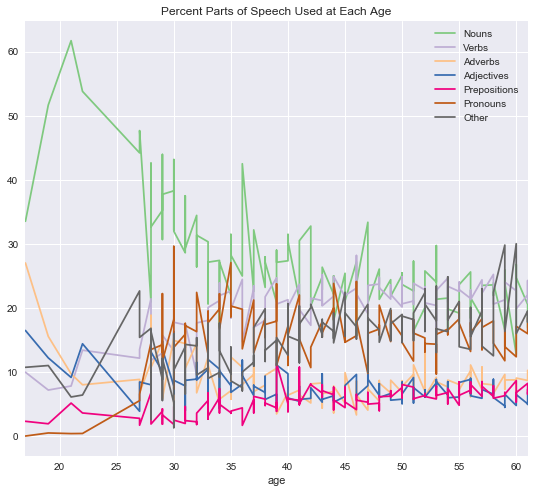

In [213]:
pos_df = df[['age', '%nouns', '%verbs', '%adverbs', '%adjectives',
                       '%prepositions', '%pronouns', '%other']]

pos_df = pos_df.set_index('age')
pos_df.columns = ['Nouns', 'Verbs', 'Adverbs', 'Adjectives', 'Prepositions', 
                  'Pronouns', 'Other']
pos_df = pos_df.sort_index(ascending = True)
#print(pos_df)

_ = pos_df.plot.line(figsize = [9, 8], colormap = 'Accent', 
                     title = 'Percent Parts of Speech Used at Each Age')